# ML - Final - 2023

## Instruction

- Modify this file to be Final-<Your FirstName-[First Letter of Last Name]>, e.g., <code>Final-Chaklam-S.ipynb</code>
- This exam is open-booked; open-internet, but no interactions with human beings or ChatGPT.
- The completed exams shall be submitted at the virtual learning environment.
- All code should be **complemented with comments**, unless it's really obvious.  **We reserve the privilege to give you zero for any part of the question where the benefit of doubt is not justified**

# Coding

#### Summary
In this section, you will be dealing with a classification problem. You will be generating your own data, training and evaluating them. You will be asked to create a neural network according to the instructions.

The generating data will be a 2d-data `(28, 28)` being arranged similar to the input shape of `nn.Conv2d` with channel = 1, height = 28 and width = 28 `(batch_size, channel, height, width)`

You will then be asked to create a network consisting of 2 `nn.Conv2d` layers followed by a `nn.Linear` layer. After the `nn.Linear` layer, we send the data to a `nn.LSTM` layer where `num_layer` and `hidden_size` can be defined. This `hidden_size` is set to be the same as `num_classes`. The output of lstm is then directly returned.

Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

1. Generate a 4 class 2d-data with 70000 samples. (10 points)
- Class 0 data is sampled from a normal distribution with mean = 0, std = 1, size = `(28,28)`
- Class 1 data is sampled from a normal distribution with mean = 5, std = 1, size = `(28,28)`
- Class 2 data is sampled from a normal distribution with mean = 15, std = 1, size = `(28,28)`
- Class 3 data is sampled from a normal distribution with mean = 20, std = 1, size = `(28,28)`

The final shape of *x* should be `(70000, 1, 28, 28)` and *y* should be `(70000,)`

In [2]:
import numpy as np

# Set random seed for reproducibility
np.random.seed(42)

# Number of samples per class
num_samples = 70000 // 4

# Generate Class 0 data
class_0_data = np.random.normal(loc=0, scale=1, size=(num_samples, 28, 28))

# Generate Class 1 data
class_1_data = np.random.normal(loc=5, scale=1, size=(num_samples, 28, 28))

# Generate Class 2 data
class_2_data = np.random.normal(loc=15, scale=1, size=(num_samples, 28, 28))

# Generate Class 3 data
class_3_data = np.random.normal(loc=20, scale=1, size=(num_samples, 28, 28))

# Concatenate data for all classes
x = np.concatenate([class_0_data, class_1_data, class_2_data, class_3_data], axis=0)

# Create labels (y)
y = np.concatenate([
    np.zeros(num_samples),
    np.ones(num_samples),
    2 * np.ones(num_samples),
    3 * np.ones(num_samples)
])

# Shuffle the data and labels
permutation = np.random.permutation(x.shape[0])
x = x[permutation]
y = y[permutation]

# Add channel dimension to the data
x = x[:, np.newaxis, :, :]

# Convert to float32 for compatibility with PyTorch
x = x.astype(np.float32)
y = y.astype(np.int64)

# Print the shapes of x and y
print("Shape of x:", x.shape)
print("Shape of y:", y.shape)


Shape of x: (70000, 1, 28, 28)
Shape of y: (70000,)


In case you are unable to do question 1, Use the following lines of code to generate your data and continue with question 3. But be aware that no marks will be given to question 1 and question 2

In [11]:
import torchvision
training_data = torchvision.datasets.MNIST('./data/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.5,), (0.5,))
                             ]))

testing_data  = torchvision.datasets.MNIST('./data/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.5,), (0.5,))
                             ]))

2. Split your data into train and test with the split ratio of 1/7 (5 points)

In [4]:
# Split the data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=1/7, random_state=42)

# Print the shapes of the resulting sets
print("Shape of x_train:", x_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of x_test:", x_test.shape)
print("Shape of y_test:", y_test.shape)


Shape of x_train: (60000, 1, 28, 28)
Shape of y_train: (60000,)
Shape of x_test: (10000, 1, 28, 28)
Shape of y_test: (10000,)


3. Check the size of your train and test sets (5 points)

In [5]:
# Print the sizes of the train and test sets
print("Size of x_train:", len(x_train))
print("Size of y_train:", len(y_train))
print("Size of x_test:", len(x_test))
print("Size of y_test:", len(y_test))

Size of x_train: 60000
Size of y_train: 60000
Size of x_test: 10000
Size of y_test: 10000


4. Set up your train and test loader with a batch size of 32 and `shuffle = True` (10 points)

In [6]:
# Convert NumPy arrays to PyTorch tensors
x_train_tensor = torch.from_numpy(x_train)
y_train_tensor = torch.from_numpy(y_train)

x_test_tensor = torch.from_numpy(x_test)
y_test_tensor = torch.from_numpy(y_test)

# Create TensorDatasets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

# Set up DataLoaders
batch_size = 32
shuffle = True

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=shuffle)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=shuffle)

# Print the number of batches in each loader
print("Number of batches in train loader:", len(train_loader))
print("Number of batches in test loader:", len(test_loader))

Number of batches in train loader: 1875
Number of batches in test loader: 313


5. Check the shape of your batch. It should be `[batchsize = 32, channel = 1, height = 28, width = 28]` (5 points)

In [7]:
# Get one batch from the train loader
for batch in train_loader:
    x_batch, y_batch = batch
    break

# Print the shape of the batch
print("Shape of the batch (x):", x_batch.shape)
print("Shape of the batch (y):", y_batch.shape)


Shape of the batch (x): torch.Size([32, 1, 28, 28])
Shape of the batch (y): torch.Size([32])


6. Plot 6 samples of any classes (10 points)

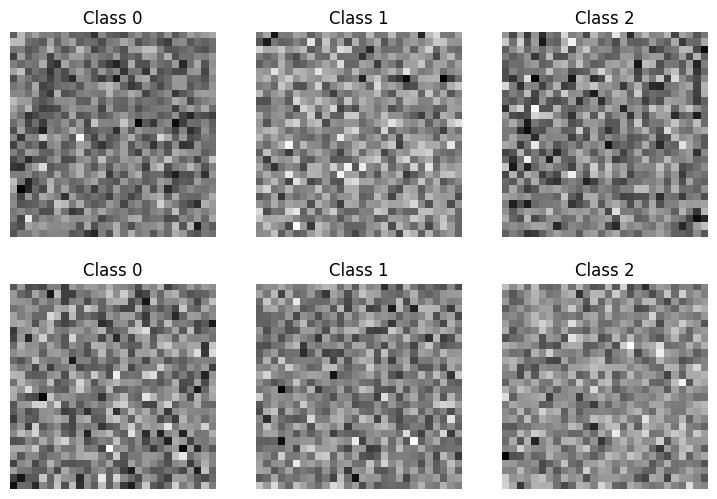

In [10]:
# Define a function to plot samples
def plot_samples(images, labels, class_names, num_samples=2):
    fig, axes = plt.subplots(num_samples, len(class_names), figsize=(len(class_names) * 3, num_samples * 3))

    for i in range(num_samples):
        for j, class_name in enumerate(class_names):
            # Find the index of a sample from the specified class
            index = np.where(labels == class_name)[0][i]

            # Plot the sample
            axes[i, j].imshow(images[index, 0], cmap='gray')
            axes[i, j].set_title(f"Class {class_name}")
            axes[i, j].axis('off')

# Define class names and plot 6 samples
class_names = [0, 1, 2]
plot_samples(x_train, y_train, class_names)

If you use MNIST

7. Configure your device. (5 points)

In [64]:
# Check if a GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device configured:", device)

Device configured: cpu


8. Define your class called `Net` with the following layers (40 points)
- cnn2d layer 1 with `in_channel = 1`, `out_channel = 10`, `kernel size = 5`, dropout of `p = 0.5`, `maxpool` and `relu` as its activation function
- cnn2d layer 2 with `in_channel = 10`, `out_channel = 20`, `kernel size = 5`, dropout of `p = 0.5`, `maxpool` and `relu` as its activation function
- linear layer with output of 25
- lstm with `num_layer = 2` and set hidden size to be num_classes




In [65]:
class Net(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Net, self).__init__()

        # CNN2d Layer 1
        self.cnn1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5),
            nn.Dropout2d(p=0.5),
            nn.MaxPool2d(2),
            nn.ReLU()
        )

        # CNN2d Layer 2
        self.cnn2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5),
            nn.Dropout2d(p=0.5),
            nn.MaxPool2d(2),
            nn.ReLU()
        )

        # Flatten before Linear Layer
        self.flatten = nn.Flatten()

        # Linear Layer
        self.linear = nn.Linear(20 * input_size * input_size, 25)

        # LSTM Layer
        self.lstm = nn.LSTM(input_size=25, hidden_size=num_classes, num_layers=2, batch_first=True)

    def forward(self, x):
        # Apply CNN2d Layer 1
        x = self.cnn1(x)

        # Apply CNN2d Layer 2
        x = self.cnn2(x)

        # Flatten before Linear Layer
        x = self.flatten(x)

        # Apply Linear Layer
        x = self.linear(x)

        # Expand dimensions for LSTM input
        x = x.unsqueeze(1)

        # Apply LSTM Layer
        lstm_out, _ = self.lstm(x)

        # Return the output of the last time step
        return lstm_out[:, -1, :]


9. Create a model object with `num_layers of lstm = 2`, `hidden_size` and `num_classes = 4` (10 points)

If you use MNIST hidden_size and  `num_classes = 10`


In [66]:
# Define the parameters
input_size = 4 
num_classes = 4
num_lstm_layers = 2
hidden_size = num_classes
# Create an instance of the Net class
model = Net(input_size, num_classes)

# Print the model architecture
print(model)


Net(
  (cnn1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
    (1): Dropout2d(p=0.5, inplace=False)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
  )
  (cnn2): Sequential(
    (0): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
    (1): Dropout2d(p=0.5, inplace=False)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=320, out_features=25, bias=True)
  (lstm): LSTM(25, 4, num_layers=2, batch_first=True)
)


10. Define an appropriate loss function for classification of this dataset (2.5 points)

In [67]:
# Define the loss function
criterion = nn.CrossEntropyLoss()

11. Define your optimizer as `Adam` with learning rate of `0.001` (5 points)

In [68]:
# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

12. Define your train function and train your model with `n_epoch = 3` (15 points)

In [69]:
# Function to train the model and return losses and accuracies
def train_model(model, train_loader, criterion, optimizer, n_epochs):
    train_losses = []
    train_accuracies = []

    for epoch in range(n_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        for inputs, labels in train_loader:
            # Move data to the device
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Calculate the loss
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

        # Calculate average loss and accuracy for the epoch
        average_loss = running_loss / len(train_loader)
        accuracy = correct_predictions / total_samples

        # Store the losses and accuracies
        train_losses.append(average_loss)
        train_accuracies.append(accuracy)

        # Print the average loss and accuracy for the epoch
        print(f"Epoch {epoch + 1}/{n_epochs}, Loss: {average_loss}, Accuracy: {accuracy}")

    return train_losses, train_accuracies

# Train the model for 3 epochs and get losses and accuracies
n_epochs = 3
train_losses, train_accuracies = train_model(model, train_loader, criterion, optimizer, n_epochs)

Epoch 1/3, Loss: 1.049230934302012, Accuracy: 0.5952166666666666
Epoch 2/3, Loss: 0.9188916748046875, Accuracy: 0.6213
Epoch 3/3, Loss: 0.9082177054087321, Accuracy: 0.6194166666666666


13. Plot your train losses and accuracies (10 points)

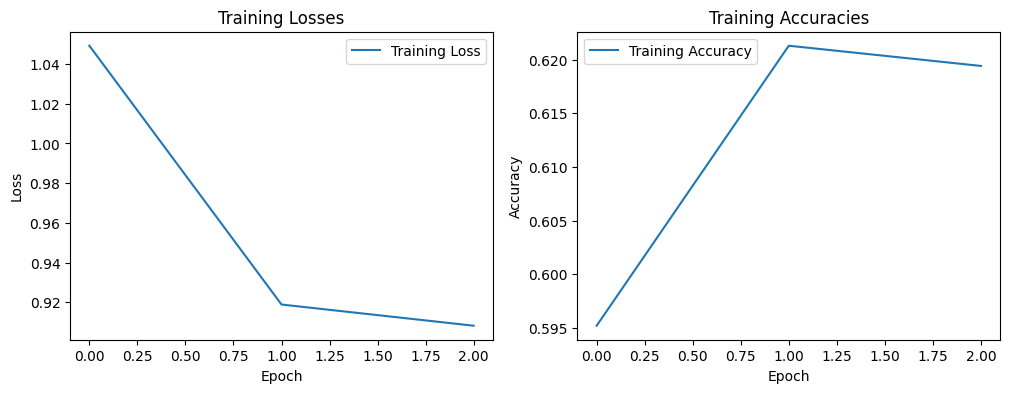

In [70]:
# Plot the training losses and accuracies
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracies')
plt.legend()

plt.show()

14. Evaluate your model with your test set (10 points)

In [71]:
# Function to evaluate the model on the test set
def evaluate_model(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            # Move data to the device
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)

            # Calculate the loss
            loss = criterion(outputs, labels)

            test_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    # Calculate average loss and accuracy for the test set
    average_loss = test_loss / len(test_loader)
    accuracy = correct_predictions / total_samples

    print(f"Test Loss: {average_loss}, Test Accuracy: {accuracy}")

# Evaluate the model on the test set
evaluate_model(model, test_loader, criterion)

Test Loss: 0.775363913740213, Test Accuracy: 0.7468


## Observations:
- The model might benefit from more training epochs to further improve accuracy.
-  Hyperparameters such as learning rate, dropout rate, and the number of LSTM layers to optimize performance